In [1]:
import seaborn as sns
iris = sns.load_dataset('iris')
iris.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


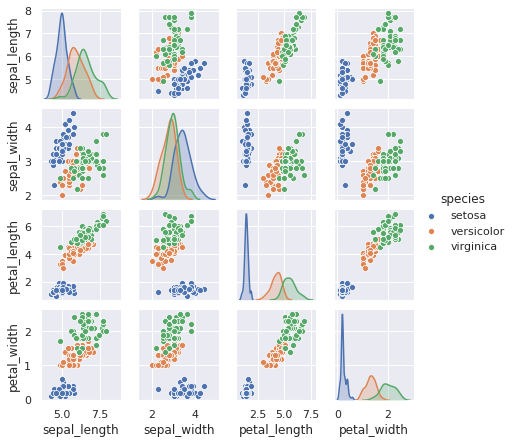

In [2]:
%matplotlib inline
sns.set()
sns.pairplot(iris, hue='species', height=1.5)

In [3]:
X_iris = iris.drop('species', axis=1)
X_iris.shape

(150, 4)

In [4]:
y_iris = iris['species']
y_iris.shape

(150,)

## Использование API scikit-learn

- импорт соответствующего класса estimator из библиотеки
- выбор гиперпараметров, создание экземпляра класса
- компоновка данных в матрицу признаков и вектор целей (scikit-learn поддерживает numpy массивы и в некоторых случаях scypy разреженные матрицы. Массивы pandas придется перегнать в numpy)
- обучение методом fit()
- получение прдсказаний для обучения с учителем через метод predict()
- преобразование для обучения без учителя с методом transform() или предсказание (для кластеризации) методом predict()
- fit() и transform() использются так-же для препроцессинга данных

In [5]:
import matplotlib.pyplot as plt
import numpy as np

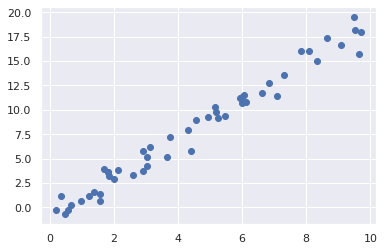

In [6]:
rnd = np.random.RandomState(42)
x = 10 * rnd.rand(50)
y = 2 * x - 1 + rnd.randn(50)
plt.scatter(x, y)

#### Выбор модели

In [7]:
from sklearn.linear_model import LinearRegression

#### Выбор гиперпараметров. Создание экземпляра estimator

подбор точки пересечения с осью координат

In [8]:
model = LinearRegression(fit_intercept=True)
model

LinearRegression()

#### Подготовка данных


In [9]:
x.shape

(50,)

In [10]:
y.shape

(50,)

In [11]:
X = x[:, np.newaxis]
X.shape

(50, 1)

#### Обучение

In [12]:
model.fit(X, y)

LinearRegression()

In [13]:
model.coef_

array([1.9776566])

In [14]:
model.intercept_

-0.9033107255311146

Это угловой коэфициент и точка пересечения с осью координат для нашей модели.

#### Получение предсказаний

создадим новые данные, которыек будем предсказывать

In [15]:
xfit = np.linspace(-1, 11) 

In [16]:
Xfit = xfit[:, np.newaxis]
yfit = model.predict(Xfit)

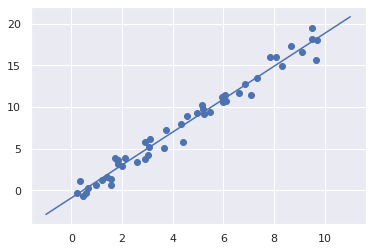

In [17]:
plt.scatter(x, y)
plt.plot(xfit, yfit)

### Наивный баесовский классификатор для ириса (обучение с учителем)

Предположим, что все распределения в датасете взяты из выровненного по осям координат гаусова распределения. Разделим данные на трейн/тест.

In [18]:
from sklearn.model_selection import train_test_split

In [19]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X_iris, y_iris, random_state=1)

In [20]:
# модель
from sklearn.naive_bayes import GaussianNB
model = GaussianNB()

In [21]:
model.fit(Xtrain, ytrain)

GaussianNB()

In [22]:
y_model = model.predict(Xtest)

In [23]:
# точность
from sklearn.metrics import accuracy_score
accuracy_score(ytest, y_model)

0.9736842105263158

### Обучение без учителя (понижение размерности)

Используем PCA для ириса (там 4 признака, снизим до двух измеренеий)

In [24]:
from sklearn.decomposition import PCA
model = PCA(n_components=2)
model.fit(X_iris)
X_2D = model.transform(X_iris)

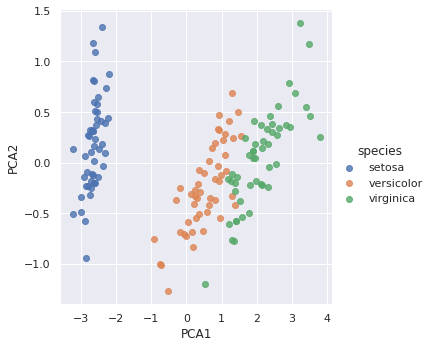

In [25]:
iris['PCA1'] = X_2D[:, 0]
iris['PCA2'] = X_2D[:, 1]
sns.lmplot('PCA1', 'PCA2', hue='species', data=iris, fit_reg=False)

### Обучение без учителя (кластеризация)

Используем GMM (gausian mixture model)

In [26]:
from sklearn.mixture import GaussianMixture
model = GaussianMixture(n_components=3, covariance_type='full')

In [27]:
model.fit(X_iris)

GaussianMixture(n_components=3)

In [28]:
y_gmm = model.predict(X_iris)

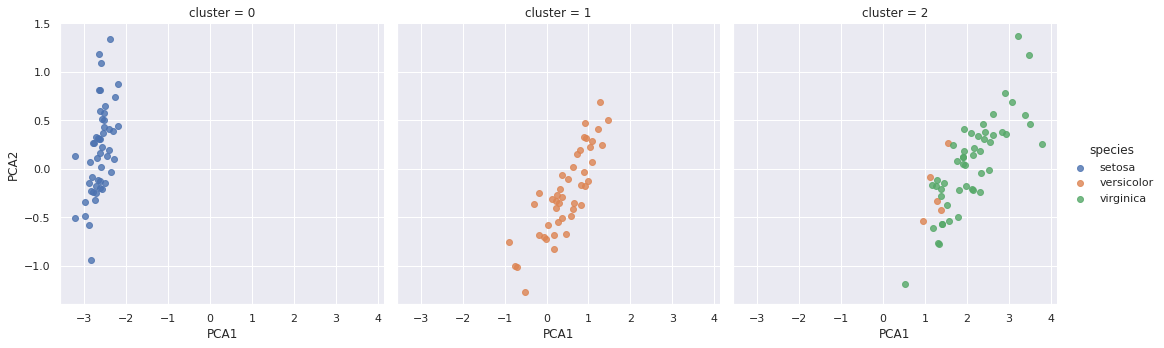

In [29]:
iris['cluster'] = y_gmm
sns.lmplot('PCA1', 'PCA2', hue='species', data=iris, col='cluster', fit_reg=False)

### Анализ рукописных цифр

In [30]:
from sklearn.datasets import load_digits
digits = load_digits()
digits.images.shape

(1797, 8, 8)

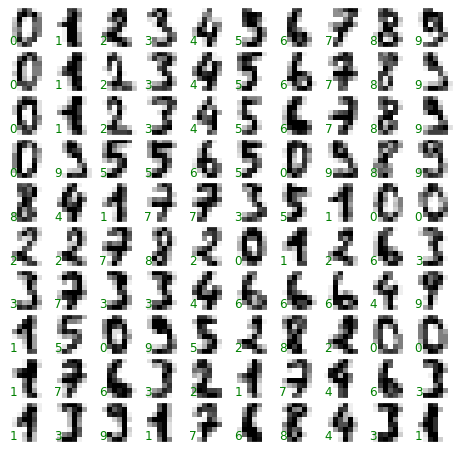

In [31]:
# визуализация первых 100 изображений
fig, axes = plt.subplots(10, 10, figsize=(8, 8),
                      subplot_kw={'xticks':[], 'yticks':[]},
                      gridspec_kw=dict(hspace=0.1, wspace=0.1))
for i, ax in enumerate(axes.flat):
    ax.imshow(digits.images[i], cmap='binary',
             interpolation='nearest')
    ax.text(0.05, 0.05, str(digits.target[i]),
           transform=ax.transAxes, color='green')

Получим для изображения 8х8 вектор 64, где каждое значение - это пиксел в изображении. y - набор целей.

In [32]:
X = digits.data
X.shape

(1797, 64)

In [33]:
y = digits.target
y.shape

(1797,)

#### Понижение размерности

снизим 64-мерное пространство до двухмерного с помощью Isomap

In [34]:
from sklearn.manifold import Isomap
iso = Isomap(n_components=2)
iso.fit(X)
data_projected = iso.transform(X)
data_projected.shape

(1797, 2)

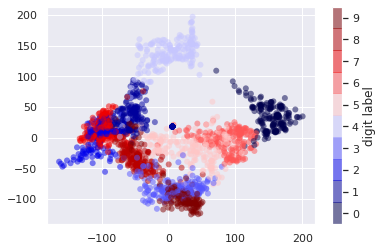

In [35]:
plt.scatter(data_projected[:, 0], data_projected[:, 1],
           c=y, edgecolor='none', alpha=0.5,
           cmap=plt.cm.get_cmap('seismic', 10))
plt.colorbar(label='digit label', ticks=range(10))
plt.clim(-0.5, 9.5)

#### классификация

используем туже наивную баесовскую модель, что и для ириса

In [36]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, random_state=0)

In [37]:
model = GaussianNB()
model.fit(Xtrain, ytrain)
y_model = model.predict(Xtest)

In [38]:
accuracy_score(ytest, y_model)

0.8333333333333334

Confusion matrix помогает понять где модель чаще всего ошибается

Text(89.18, 0.5, 'true')

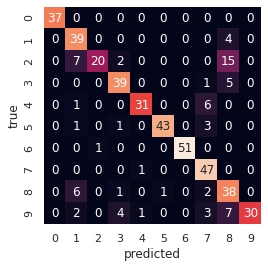

In [39]:
from sklearn.metrics import confusion_matrix
matr = confusion_matrix(ytest, y_model)
sns.heatmap(matr,square=True, annot=True, cbar=False)
plt.xlabel('predicted')
plt.ylabel('true')

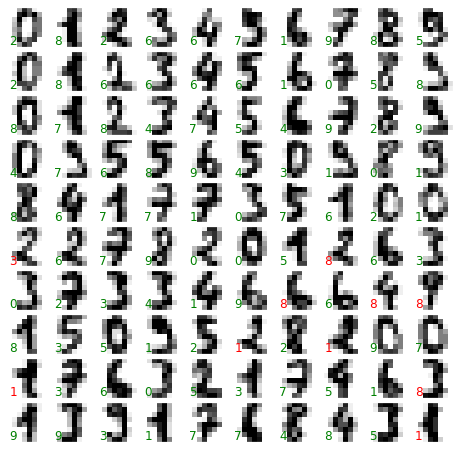

In [40]:
# можно вывести входные данные с предсказакныыми метками
fig, axes = plt.subplots(10, 10, figsize=(8, 8),
                      subplot_kw={'xticks':[], 'yticks':[]},
                      gridspec_kw=dict(hspace=0.1, wspace=0.1))
for i, ax in enumerate(axes.flat):
    ax.imshow(digits.images[i], cmap='binary',
             interpolation='nearest')
    ax.text(0.05, 0.05, str(y_model[i]),
           transform=ax.transAxes,
            color='green' if (ytest[i] == y_model[i]) else 'red')

### Проверка модели (validation curve)

будем использовать простую линейную регрессию с полиномиальным препроцессингом в пайплайне

In [41]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline

In [42]:
def pol_reg(degree=2, **kwargs):
    return make_pipeline(PolynomialFeatures(degree),
                        LinearRegression(**kwargs))

In [43]:
# создадим данные
def make_data(N, err=1.0, rseed=1):
    rng = np.random.RandomState(rseed)
    X = rnd.rand(N, 1) ** 2
    y = 10 - 1. / (X.ravel() + 0.1)
    if err > 0:
        y += err * rnd.randn(N)
    
    return X, y

In [44]:
X, y = make_data(40)

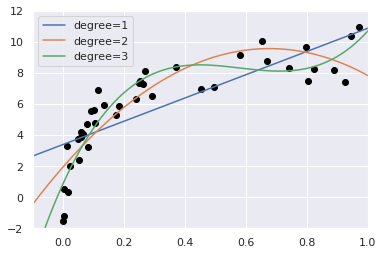

In [45]:
X_test = np.linspace(-0.1, 1.1, 500)[:, None]

plt.scatter(X.ravel(), y, color='black')
axis = plt.axis()
for degree in [1, 2, 3]:
    y_test = pol_reg(degree).fit(X, y).predict(X_test)
    plt.plot(X_test.ravel(), y_test, label='degree={0}'.format(degree))
plt.xlim(-0.1, 1.0)
plt.ylim(-2, 12)
plt.legend(loc='best')

визуализируем кривую проверки с помощью validation_curve. Функция получает на вход модель, данные, назвение параметра и диапазон для анализа. Затем вычисляется значения для оценки эффективности модели.

In [46]:
from sklearn.model_selection import validation_curve


In [47]:
degree = np.arange(0, 21) # степень полинома
train_score, val_score = validation_curve(pol_reg(), X, y,
                                         'polynomialfeatures__degree',
                                         degree, cv=7)

/home/konstantin/anaconda3/envs/ml-base/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass param_name=polynomialfeatures__degree, param_range=[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


Text(0, 0.5, 'score')

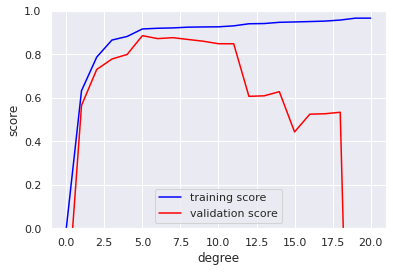

In [48]:
plt.plot(degree, np.median(train_score, 1), color='blue', label='training score')
plt.plot(degree, np.median(val_score, 1), color='red', label='validation score')
plt.legend(loc='best')
plt.ylim(0, 1)
plt.xlabel('degree')
plt.ylabel('score')


(-0.04852459215955282,
 1.020079741966909,
 -2.1697496484420618,
 11.556426428423329)

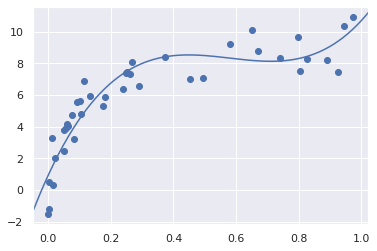

In [49]:
# оптимальный вариант - степень 5
plt.scatter(X.ravel(), y)
lim = plt.axis()
y_test = pol_reg(3).fit(X, y).predict(X_test)
plt.plot(X_test.ravel(), y_test)
plt.axis(lim)

Поведение кривых проверки зависят от двух факторов:

- сложности модели
- количества точек обучения

Бывает важно исследовать поаедения модели от количества точек обучения. Это можно реализовать за счет постепенно увеличивающегося подмножества данных обучения.

### кривые обучения (learning curve)

это график оценок обучения/проверки с учетом размера обучающей выборки. Должен вести себя так:

- переобучение на слишком маленьком наборе данных
- недообучение на слишком большом наборе
- на проверке всегда хуже, чем при обучении

Если достигнута точка, при которой данная конкретная модель сошлась, то добавление новых обучающих данных уже ничего не даст.

/home/konstantin/anaconda3/envs/ml-base/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass param_name=polynomialfeatures__degree, param_range=[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


Text(0, 0.5, 'score')

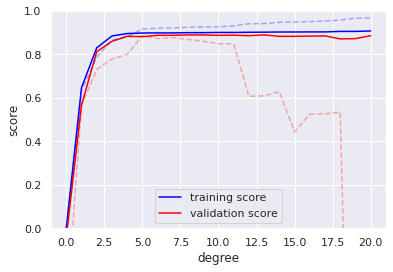

In [50]:
X2, y2 = make_data(200)
degree = np.arange(21)
train_score2, val_score2 = validation_curve(pol_reg(), X2, y2,
                                            'polynomialfeatures__degree', degree, cv=7)

plt.plot(degree, np.median(train_score2, 1), color='blue', label='training score')
plt.plot(degree, np.median(val_score2, 1), color='red', label='validation score')
plt.plot(degree, np.median(train_score, 1), color='blue', alpha=0.3, linestyle='dashed')
plt.plot(degree, np.median(val_score, 1), color='red', alpha=0.3, linestyle='dashed')
plt.legend(loc='lower center')
plt.ylim(0, 1)
plt.xlabel('degree')
plt.ylabel('score')

In [51]:
from sklearn.model_selection import learning_curve

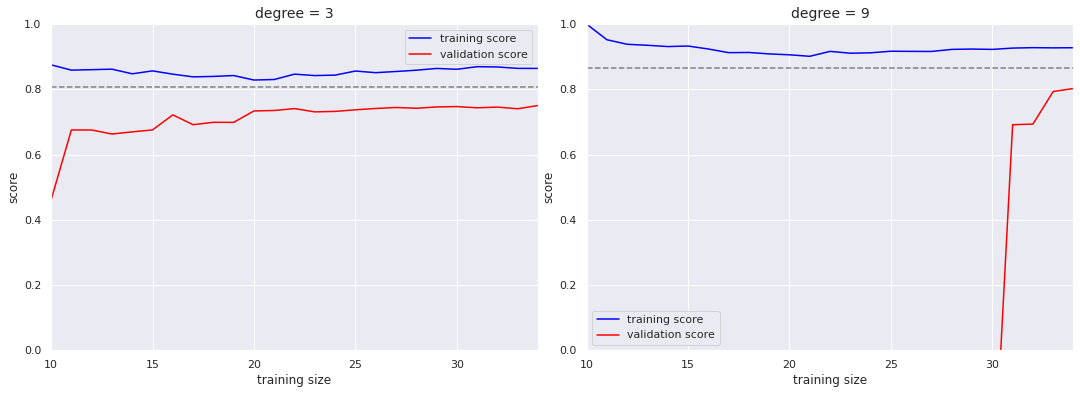

In [52]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)

for i, degree in enumerate([3, 9]):
    N, train_lc, val_lc = learning_curve(pol_reg(degree),
                                        X, y, cv=7,
                                        train_sizes=np.linspace(0.3, 1, 25))

    ax[i].plot(N, np.mean(train_lc, 1), color='blue', label='training score')
    ax[i].plot(N, np.mean(val_lc, 1), color='red', label='validation score')
    ax[i].hlines(np.mean([train_lc[-1], val_lc[-1]]), N[0], N[-1],
                 color='gray', linestyle='dashed')

    ax[i].set_ylim(0, 1)
    ax[i].set_xlim(N[0], N[-1])
    ax[i].set_xlabel('training size')
    ax[i].set_ylabel('score')
    ax[i].set_title('degree = {0}'.format(degree), size=14)
    ax[i].legend(loc='best')

Добавление данных в простую модель не улучшает результат, т.к. модель быстро сошлась. Улучшить модель теперь можно только усложнив ее (т.е., в данном случае, увеличив степень). Однако бесконечно усложнаять модель не получится - переобучение.

### Гридсерч

Т.к. у модели обычно много параметров, построить кривые опроверки не представляется возможным. В этом случае лучше отыскать конкретную модель, для которой оценка эффективности достигала максимум.

In [53]:
from sklearn.model_selection import GridSearchCV
param_geid = {'polynomialfeatures__degree': np.arange(21),
             'linearregression__fit_intercept': [True, False],
             'linearregression__normalize': [True, False]}

In [54]:
grid = GridSearchCV(pol_reg(), param_geid, cv=7)

In [55]:
grid.fit(X, y)

GridSearchCV(cv=7,
             estimator=Pipeline(steps=[('polynomialfeatures',
                                        PolynomialFeatures()),
                                       ('linearregression',
                                        LinearRegression())]),
             param_grid={'linearregression__fit_intercept': [True, False],
                         'linearregression__normalize': [True, False],
                         'polynomialfeatures__degree': array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20])})

In [56]:
model = grid.best_estimator_

(-0.04852459215955282,
 1.020079741966909,
 -2.1697496484420618,
 11.556426428423329)

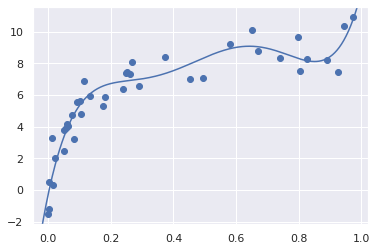

In [57]:
plt.scatter(X.ravel(), y)
lim = plt.axis()
y_test = model.fit(X, y).predict(X_test)
plt.plot(X_test.ravel(), y_test)
plt.axis(lim)

## Проектирование признаков

#### для one hot encoding

In [58]:
data = [
    {'price': 850000, 'rooms': 4, 'neighborhood': 'Queen Anne'},
    {'price': 700000, 'rooms': 3, 'neighborhood': 'Fremont'},
    {'price': 650000, 'rooms': 3, 'neighborhood': 'Wallingford'},
    {'price': 600000, 'rooms': 2, 'neighborhood': 'Fremont'}
]

In [59]:
from sklearn.feature_extraction import DictVectorizer
vec = DictVectorizer(sparse=False, dtype=int)
vec.fit_transform(data)

array([[     0,      1,      0, 850000,      4],
       [     1,      0,      0, 700000,      3],
       [     0,      0,      1, 650000,      3],
       [     1,      0,      0, 600000,      2]])

In [60]:
vec.get_feature_names()

['neighborhood=Fremont',
 'neighborhood=Queen Anne',
 'neighborhood=Wallingford',
 'price',
 'rooms']

Чтобы не плодить громадные пустые матрицы, можно использорвать разреженную (не все прогнозаторы принимают)

In [61]:
vec = DictVectorizer(sparse=True, dtype=int)
vec.fit_transform(data)

<4x5 sparse matrix of type '<class 'numpy.int64'>'
	with 12 stored elements in Compressed Sparse Row format>

In [62]:
# другие варианты
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction import FeatureHasher

#### векторизация текстов

In [63]:
sample = ['problem of evil',
          'evil queen',
          'horizon problem']

In [64]:
from sklearn.feature_extraction.text import CountVectorizer

In [65]:
vec = CountVectorizer()
X = vec.fit_transform(sample)
X

<3x5 sparse matrix of type '<class 'numpy.int64'>'
	with 7 stored elements in Compressed Sparse Row format>

In [66]:
import pandas as pd
pd.DataFrame(X.toarray(), columns=vec.get_feature_names())

,evil,horizon,of,problem,queen
0,1,0,1,1,0
1,1,0,0,0,1
2,0,1,0,1,0


В sklearn есчть реализация TF-IDF, когда слова получают вес с учетом частоты их появления в документе

In [67]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [68]:
vec = TfidfVectorizer()
X = vec.fit_transform(sample)
pd.DataFrame(X.toarray(), columns=vec.get_feature_names())

,evil,horizon,of,problem,queen
0,0.517856,0.000000,0.680919,0.517856,0.000000
1,0.605349,0.000000,0.000000,0.000000,0.795961
2,0.000000,0.795961,0.000000,0.605349,0.000000


#### обработка изображений

[scikit-image](https://scikit-image.org/)

#### заполнение пропусков

In [69]:
from numpy import nan
X = np.array([[ nan, 0,   3  ],
              [ 3,   7,   9  ],
              [ 3,   5,   2  ],
              [ 4,   nan, 6  ],
              [ 8,   8,   1  ]])
y = np.array([14, 16, -1,  8, -5])

In [70]:
from sklearn.impute import SimpleImputer
imp = SimpleImputer(strategy='mean')
X2 = imp.fit_transform(X)
X2

array([[4.5, 0. , 3. ],
       [3. , 7. , 9. ],
       [3. , 5. , 2. ],
       [4. , 5. , 6. ],
       [8. , 8. , 1. ]])

#### полиномиальные признаки

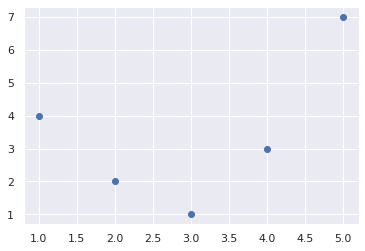

In [71]:
x = np.array([1, 2, 3, 4, 5])
y = np.array([4, 2, 1, 3, 7])
plt.scatter(x, y)

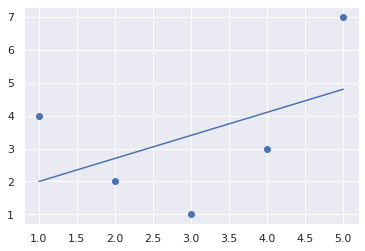

In [72]:
X = x[:, np.newaxis]
model = LinearRegression().fit(X, y)
yfit = model.predict(X)
plt.scatter(x, y)
plt.plot(x, yfit)

In [73]:
poly = PolynomialFeatures(degree=3, include_bias=False)
X2 = poly.fit_transform(X)
print(X2)

[[  1.   1.   1.]
 [  2.   4.   8.]
 [  3.   9.  27.]
 [  4.  16.  64.]
 [  5.  25. 125.]]


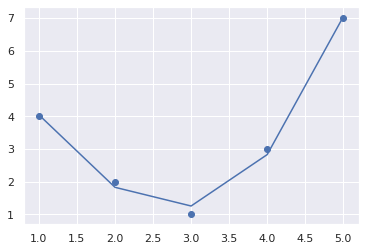

In [74]:
model = LinearRegression().fit(X2, y)
yfit = model.predict(X2)
plt.scatter(x, y)
plt.plot(x, yfit)

#### конвеер признаков


- добавить отсутствующие данные
- преобразовать признаки
- обучить модель

In [75]:
from sklearn.pipeline import make_pipeline

model = make_pipeline(SimpleImputer(strategy='mean'),
                     PolynomialFeatures(degree=2),
                     LinearRegression())

In [76]:
X = np.array([[ nan, 0,   3  ],
              [ 3,   7,   9  ],
              [ 3,   5,   2  ],
              [ 4,   nan, 6  ],
              [ 8,   8,   1  ]])
y = np.array([14, 16, -1,  8, -5])

In [77]:
model.fit(X, y)
print(y)
print(model.predict(X))

[14 16 -1  8 -5]
[14. 16. -1.  8. -5.]


### пример с велосипедистами на бруклинском мосту

In [78]:
import pandas as pd
# данные по велосипедистам на фримонтском мосту
counts = pd.read_csv('pythonPDSH/notebooks/data/FremontBridge.csv', index_col='Date', parse_dates=True)
# данные по погоде
weather = pd.read_csv('pythonPDSH/notebooks/data/BicycleWeather.csv', index_col='DATE', parse_dates=True)

In [79]:
counts.head(2)

,Fremont Bridge West Sidewalk,Fremont Bridge East Sidewalk
Date,,
2012-10-03 00:00:00,4.0,9.0
2012-10-03 01:00:00,4.0,6.0


In [80]:
weather.head(2)

,STATION,STATION_NAME,PRCP,SNWD,SNOW,TMAX,TMIN,AWND,WDF2,WDF5,...,WT17,WT05,WT02,WT22,WT04,WT13,WT16,WT08,WT18,WT03
DATE,,,,,,,,,,,,,,,,,,,,,
2012-01-01,GHCND:USW00024233,SEATTLE TACOMA INTERNATIONAL AIRPORT WA US,0,0,0,128,50,47,100,90,...,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999
2012-01-02,GHCND:USW00024233,SEATTLE TACOMA INTERNATIONAL AIRPORT WA US,109,0,0,106,28,45,180,200,...,-9999,-9999,-9999,-9999,-9999,1,1,-9999,-9999,-9999


In [81]:
# общий ежедневный поток велосипедиство в отдельном датафрейме
daily = counts.resample('d').sum()
daily['Total'] = daily.sum(axis=1)
daily = daily[['Total']] # remove other columns

In [82]:
# проиндексируем поездки по дням
days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
for i in range(7):
    daily[days[i]] = (daily.index.dayofweek == i).astype(float)

In [83]:
# проиндексируем выходные дни
from pandas.tseries.holiday import USFederalHolidayCalendar
cal = USFederalHolidayCalendar()
holidays = cal.holidays('2012', '2016')
daily = daily.join(pd.Series(1, index=holidays, name='holiday'))
daily['holiday'].fillna(0, inplace=True)

In [84]:
# добавим расчеты по длительности светового дня
def hours_of_daylight(date, axis=23.44, latitude=47.61):
    """Compute the hours of daylight for the given date"""
    days = (date - pd.datetime(2000, 12, 21)).days
    m = (1. - np.tan(np.radians(latitude))
         * np.tan(np.radians(axis) * np.cos(days * 2 * np.pi / 365.25)))
    return 24. * np.degrees(np.arccos(1 - np.clip(m, 0, 2))) / 180.

/home/konstantin/anaconda3/envs/ml-base/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  after removing the cwd from sys.path.


(8.0, 17.0)

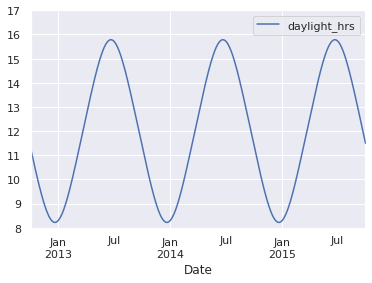

In [85]:
daily['daylight_hrs'] = list(map(hours_of_daylight, daily.index))
daily[['daylight_hrs']].plot()
plt.ylim(8, 17)

In [86]:
# добавим к данным среднюю температуру и общее количество осадков. Обозначим отдельным флагом сухие дни
# temperatures are in 1/10 deg C; convert to C
weather['TMIN'] /= 10
weather['TMAX'] /= 10
weather['Temp (C)'] = 0.5 * (weather['TMIN'] + weather['TMAX'])

# precip is in 1/10 mm; convert to inches
weather['PRCP'] /= 254
weather['dry day'] = (weather['PRCP'] == 0).astype(int)

daily = daily.join(weather[['PRCP', 'Temp (C)', 'dry day']])

In [87]:
# счетчик, считающий кол-во прошедших лет для отслеживания ежегодных измененеий кол-ва проезжающих
daily['annual'] = (daily.index - daily.index[0]).days / 365.

In [88]:
# итог
daily.head(5)

,Total,Mon,Tue,Wed,Thu,Fri,Sat,Sun,holiday,daylight_hrs,PRCP,Temp (C),dry day,annual
Date,,,,,,,,,,,,,,
2012-10-03,3521.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,11.277359,0.0,13.35,1.0,0.000000
2012-10-04,3475.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,11.219142,0.0,13.60,1.0,0.002740
2012-10-05,3148.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,11.161038,0.0,15.30,1.0,0.005479
2012-10-06,2006.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,11.103056,0.0,15.85,1.0,0.008219
2012-10-07,2142.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,11.045208,0.0,15.85,1.0,0.010959


Теперь осталось дропнуть строки с пустыми значениями и обучить лин.регрессию. fit_intercept=False, так как флаги дней определяют точки пересечения с осями координат

In [89]:
# Drop any rows with null values
daily.dropna(axis=0, how='any', inplace=True)

column_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun', 'holiday',
                'daylight_hrs', 'PRCP', 'dry day', 'Temp (C)', 'annual']
X = daily[column_names]
y = daily['Total']

model = LinearRegression(fit_intercept=False)
model.fit(X, y)
daily['predicted'] = model.predict(X)

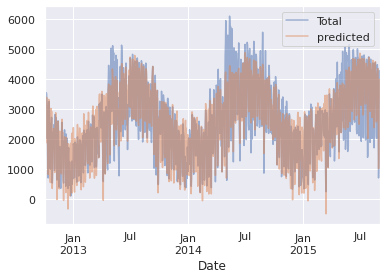

In [90]:
daily[['Total', 'predicted']].plot(alpha=0.5)

явно упущены ключевые признаки. Особенно летом. Однако грубая аппроксимация уже дает представление о трафике. Посмотрим коэфициэнты модели

In [91]:
params = pd.Series(model.coef_, index=X.columns)
params

Mon              501.529506
Tue              615.964486
Wed              589.391681
Thu              478.935936
Fri              174.454339
Sat            -1106.451896
Sun            -1136.789663
holiday        -1186.818446
daylight_hrs     128.918672
PRCP            -665.916842
dry day          543.024483
Temp (C)          65.260412
annual            29.793048
dtype: float64

Для интерпретации значений вычислим погрешност бустрапингом.

In [92]:
from sklearn.utils import resample
np.random.seed(1)
err = np.std([model.fit(*resample(X, y)).coef_
              for i in range(1000)], 0)

In [93]:
# теперь с учетом погрешностей
print(pd.DataFrame({'effect': params.round(0),
                    'error': err.round(0)}))

              effect  error
Mon            502.0   86.0
Tue            616.0   83.0
Wed            589.0   83.0
Thu            479.0   85.0
Fri            174.0   81.0
Sat          -1106.0   80.0
Sun          -1137.0   83.0
holiday      -1187.0  163.0
daylight_hrs   129.0    9.0
PRCP          -666.0   62.0
dry day        543.0   33.0
Temp (C)        65.0    4.0
annual          30.0   18.0


1. по будням велосипедистов явно больше
2. с каждым дополнительным часом в светлое время суток велосипедистов становится больше на 129 +/- 9
3. рост температуры на 1 градус дает 65 +/- 4
4. сухой день 546 +/- 33
5. каждый дюйм осадков забирает 665 +/- 62

Каждый год ежедневное кол-во вырастает на 28 +/- 18

В модели не хватает нелинейных влияний:

- совместное влияние осадков и температуры
- различие между дождливым утром и дождливым полуднем

Крмое того, мы не учитываем корреляцию между днями (влияние дождливого дня на последующие и т.д.)

### пример с распознаванием лиц

набор данных Labeled Faces in the Wild (LFW)

In [94]:
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people(min_faces_per_person=60)
print(faces.target_names)
print(faces.images.shape)

['Ariel Sharon' 'Colin Powell' 'Donald Rumsfeld' 'George W Bush'
 'Gerhard Schroeder' 'Hugo Chavez' 'Junichiro Koizumi' 'Tony Blair']
(1348, 62, 47)


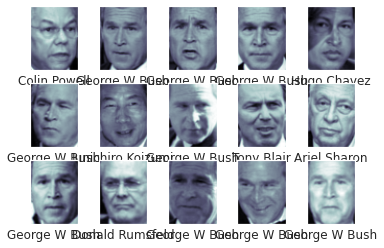

In [95]:
# несколько примеров
fig, ax = plt.subplots(3, 5)
for i, axi in enumerate(ax.flat):
    axi.imshow(faces.images[i], cmap='bone')
    axi.set(xticks=[], yticks=[],
            xlabel=faces.target_names[faces.target[i]])

каждое изображение 62х47 (т.е. примерно 3000 пикселов). Что бы не рассматривать каждый пиксел как признак, используем метод главных компонент для извлечения 150 главных компонент

In [96]:
from sklearn.svm import SVC
from sklearn.decomposition import PCA as RandomizedPCA
from sklearn.pipeline import make_pipeline

pca = RandomizedPCA(n_components=150, whiten=True, random_state=42)
svc = SVC(kernel='rbf', class_weight='balanced')
model = make_pipeline(pca, svc)

In [97]:
# трейн/тест
from sklearn.model_selection import train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(faces.data, faces.target,
                                                random_state=42)

In [98]:
# используемпоиск по сетке, с подбором C (отступ) и gamma (размер ядра rbf)
from sklearn.model_selection import GridSearchCV
param_grid = {'svc__C': [1, 5, 10, 50],
              'svc__gamma': [0.0001, 0.0005, 0.001, 0.005]}
grid = GridSearchCV(model, param_grid)

%time grid.fit(Xtrain, ytrain)
print(grid.best_params_)

CPU times: user 1min 30s, sys: 1min 41s, total: 3min 12s
Wall time: 23.3 s
{'svc__C': 10, 'svc__gamma': 0.001}


Оптимальные параметры нашлись в середине сетки. если бы по краям, то надо было бы расширить сетку, чтобы убедиться, что найден истинный оптимум. 

Получим метки для контрольных данных

In [99]:
model = grid.best_estimator_
yfit = model.predict(Xtest)

Text(0.5, 0.98, 'Predicted Names; Incorrect Labels in Red')

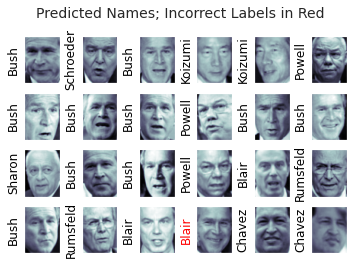

In [100]:
fig, ax = plt.subplots(4, 6)
for i, axi in enumerate(ax.flat):
    axi.imshow(Xtest[i].reshape(62, 47), cmap='bone')
    axi.set(xticks=[], yticks=[])
    axi.set_ylabel(faces.target_names[yfit[i]].split()[-1],
                   color='black' if yfit[i] == ytest[i] else 'red')
fig.suptitle('Predicted Names; Incorrect Labels in Red', size=14)

In [101]:
# выведем статистику
from sklearn.metrics import classification_report
print(classification_report(ytest, yfit,
                            target_names=faces.target_names))

                   precision    recall  f1-score   support

     Ariel Sharon       0.65      0.73      0.69        15
     Colin Powell       0.80      0.87      0.83        68
  Donald Rumsfeld       0.74      0.84      0.79        31
    George W Bush       0.92      0.83      0.88       126
Gerhard Schroeder       0.86      0.83      0.84        23
      Hugo Chavez       0.93      0.70      0.80        20
Junichiro Koizumi       0.92      1.00      0.96        12
       Tony Blair       0.85      0.95      0.90        42

         accuracy                           0.85       337
        macro avg       0.83      0.84      0.84       337
     weighted avg       0.86      0.85      0.85       337



Text(89.18, 0.5, 'predicted label')

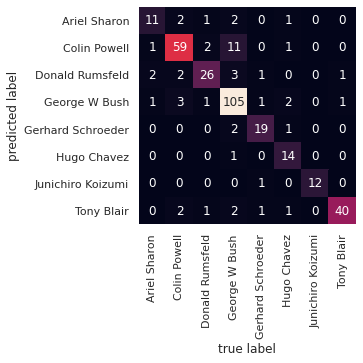

In [102]:
# матрица различий
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(ytest, yfit)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=faces.target_names,
            yticklabels=faces.target_names)
plt.xlabel('true label')
plt.ylabel('predicted label')

### случайный лес для классификации цифр

In [103]:
digits = load_digits()
digits.keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'images', 'DESCR'])

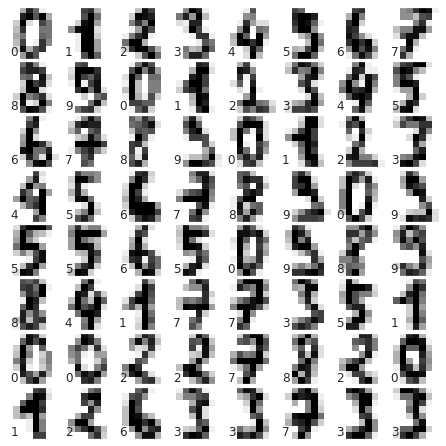

In [104]:
# визуализация
# set up the figure
fig = plt.figure(figsize=(6, 6))  # figure size in inches
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

# plot the digits: each image is 8x8 pixels
for i in range(64):
    ax = fig.add_subplot(8, 8, i + 1, xticks=[], yticks=[])
    ax.imshow(digits.images[i], cmap=plt.cm.binary, interpolation='nearest')
    
    # label the image with the target value
    ax.text(0, 7, str(digits.target[i]))

In [105]:
from sklearn.ensemble import RandomForestClassifier
Xtrain, Xtest, ytrain, ytest = train_test_split(digits.data, digits.target,
                                                random_state=0)
model = RandomForestClassifier(n_estimators=1000)
model.fit(Xtrain, ytrain)
ypred = model.predict(Xtest)

In [106]:
# посмотрим на отчет для каждого классификатора
from sklearn import metrics
print(metrics.classification_report(ypred, ytest))

              precision    recall  f1-score   support

           0       1.00      0.97      0.99        38
           1       0.98      0.98      0.98        43
           2       0.98      1.00      0.99        43
           3       0.98      0.98      0.98        45
           4       0.97      1.00      0.99        37
           5       0.98      0.96      0.97        49
           6       1.00      1.00      1.00        52
           7       1.00      0.96      0.98        50
           8       0.94      0.98      0.96        46
           9       0.98      0.98      0.98        47

    accuracy                           0.98       450
   macro avg       0.98      0.98      0.98       450
weighted avg       0.98      0.98      0.98       450



Text(89.18, 0.5, 'predicted label')

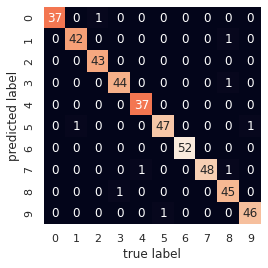

In [107]:
# матрица различий
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(ytest, ypred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label')

Достоинства

- обучение и предсказание очень быстрые
- возможно эффективное распараллеливание
- возможна вероятностная классификация, т.к. голосование дает вероятностную оценку (predict_proba() в sklearn)
- модель параметрическая и поэтому гибкая

Недостатки

- сложно интерпретировать результаты

### PCA для распознавания лиц (продолжение)

In [108]:
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people(min_faces_per_person=60)
print(faces.target_names)
print(faces.images.shape)

['Ariel Sharon' 'Colin Powell' 'Donald Rumsfeld' 'George W Bush'
 'Gerhard Schroeder' 'Hugo Chavez' 'Junichiro Koizumi' 'Tony Blair']
(1348, 62, 47)


In [109]:
# т.к. набор данных большой, используем быстрый метод RandomizedPCA
from sklearn.decomposition import PCA as RandomizedPCA
pca = RandomizedPCA(150, svd_solver='randomized')
pca.fit(faces.data)

PCA(n_components=150, svd_solver='randomized')

Визуализируем изображения, соответствующие первым нескольким главным компонентам (собственные вектора) - собственные лица.

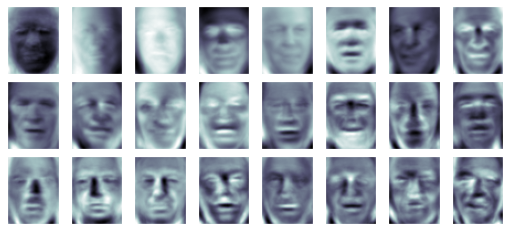

In [110]:
fig, axes = plt.subplots(3, 8, figsize=(9, 4),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))
for i, ax in enumerate(axes.flat):
    ax.imshow(pca.components_[i].reshape(62, 47), cmap='bone')

Text(0, 0.5, 'cumulative explained variance')

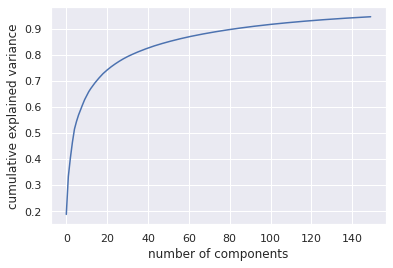

In [111]:
# интегральная дисперсия этих компонент
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

150 первых компонент отвечают за более чем 90% дисперсии. Восстановим изображения из этих компонент

In [112]:
pca = RandomizedPCA(150).fit(faces.data)
components = pca.transform(faces.data)
projected = pca.inverse_transform(components)

Text(0, 0.5, '150-dim\nreconstruction')

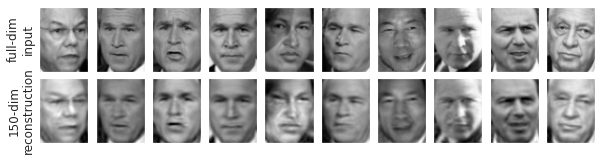

In [113]:
# Plot the results
fig, ax = plt.subplots(2, 10, figsize=(10, 2.5),
                       subplot_kw={'xticks':[], 'yticks':[]},
                       gridspec_kw=dict(hspace=0.1, wspace=0.1))
for i in range(10):
    ax[0, i].imshow(faces.data[i].reshape(62, 47), cmap='binary_r')
    ax[1, i].imshow(projected[i].reshape(62, 47), cmap='binary_r')
    
ax[0, 0].set_ylabel('full-dim\ninput')
ax[1, 0].set_ylabel('150-dim\nreconstruction')

### Isomap для распознавания лиц

обучение  на базе многообразий часто используется для исследования зависимостей между многомерными точками данных

к примеру изображение в 1000 пикселей можно рассматривать как набор точек в 1000-мерном пространстве, а яркость пикселей, как координату в соответствующем измерении.

In [114]:
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people(min_faces_per_person=30)
faces.data.shape

(2370, 2914)

В данном случае 2370 изображений размером 2914 пикселей, т.е. их можно описать точками данных в 2914-мерном пространстве.

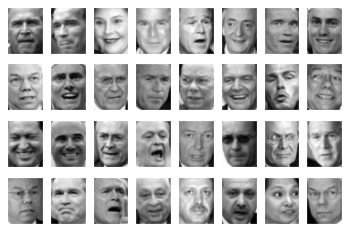

In [115]:
fig, ax = plt.subplots(4, 8, subplot_kw=dict(xticks=[], yticks=[]))
for i, axi in enumerate(ax.flat):
    axi.imshow(faces.images[i], cmap='gray')

Text(0, 0.5, 'cumulative variance')

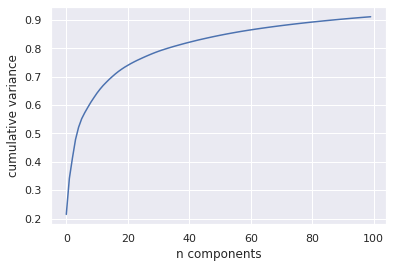

In [116]:
# используем pca , чтобы понять сколько линейных признаков нужно для описания данных
from sklearn.decomposition import PCA as RandomizedPCA
model = RandomizedPCA(100, svd_solver='randomized').fit(faces.data)
plt.plot(np.cumsum(model.explained_variance_ratio_))
plt.xlabel('n components')
plt.ylabel('cumulative variance')

В данном случае видно, что для сохраненеия 90% дисперсии надо не менее 100 компонент, что говорит о том, что данные имеют чрезвычайно высокую размерность и их невозможно описать линейно с помощью всего нескольких компонент.

используем isomap

In [117]:
from sklearn.manifold import Isomap
model = Isomap(n_components=2)
proj = model.fit_transform(faces.data)
proj.shape

(2370, 2)

In [118]:
# результьат - двумерная проекция. На визуализации - миниатюры изображений прикреплены к точкам данных проекции
from matplotlib import offsetbox

def plot_components(data, model, images=None, ax=None,
                    thumb_frac=0.05, cmap='gray'):
    ax = ax or plt.gca()
    
    proj = model.fit_transform(data)
    ax.plot(proj[:, 0], proj[:, 1], '.k')
    
    if images is not None:
        min_dist_2 = (thumb_frac * max(proj.max(0) - proj.min(0))) ** 2
        shown_images = np.array([2 * proj.max(0)])
        for i in range(data.shape[0]):
            dist = np.sum((proj[i] - shown_images) ** 2, 1)
            if np.min(dist) < min_dist_2:
                # don't show points that are too close
                continue
            shown_images = np.vstack([shown_images, proj[i]])
            imagebox = offsetbox.AnnotationBbox(
                offsetbox.OffsetImage(images[i], cmap=cmap),
                                      proj[i])
            ax.add_artist(imagebox)

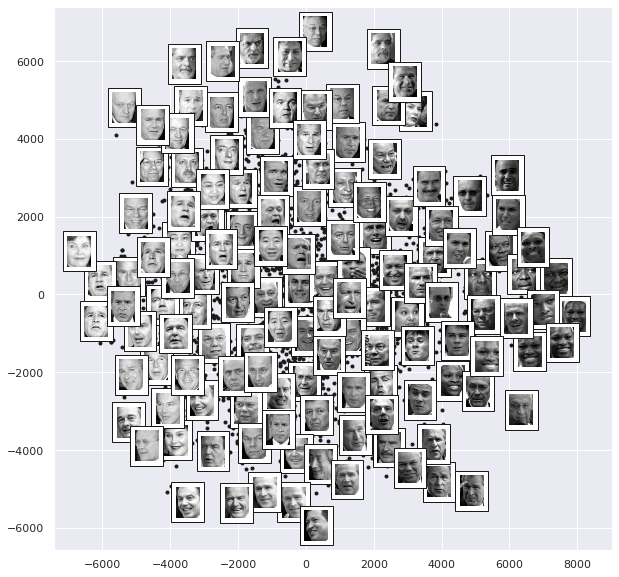

In [119]:
fig, ax = plt.subplots(figsize=(10, 10))
plot_components(faces.data,
                model=Isomap(n_components=2),
                images=faces.images[:, ::2, ::2])

Можно сделать вывод

- первые два измеренеия Isomsp описывают (вероятно) общие признаки изображения - яркость и и расположение лица

Далее можно перейти к классификации этих данных, возможно с помощью признаков на базе многообразий в качестве входных данных для алгоритма классификации.

### Визуализация структуры цифр

In [122]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784')
mnist.data.shape

(70000, 784)

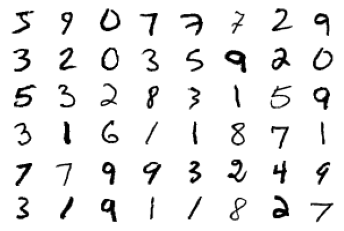

In [123]:
# Набор состоит из 70000 изображений 28х28
fig, ax = plt.subplots(6, 8, subplot_kw=dict(xticks=[], yticks=[]))
for i, axi in enumerate(ax.flat):
    axi.imshow(mnist.data[1250 * i].reshape(28, 28), cmap='gray_r')

Вычислим проекцию исп.обучение на базе многообразий. Для скорости задействуем только 1/30 часть набора

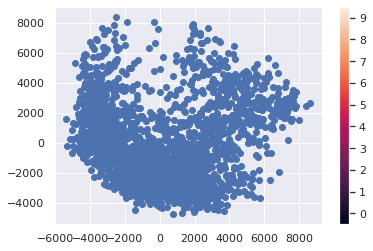

In [134]:
data = mnist.data[::30]
target = mnist.target[::30]

model = Isomap(n_components=2)
proj = model.fit_transform(data)
cmap = plt.cm.Spectral
plt.scatter(proj[:, 0], proj[:, 1], cmap=plt.cm.get_cmap('jet', 10)) # проблема с c=cmap
plt.colorbar(ticks=range(10))
plt.clim(-0.5, 9.5)

Точки расположены слишком тесно. Лучше рассматривать их, изучая за раз по одной цифре

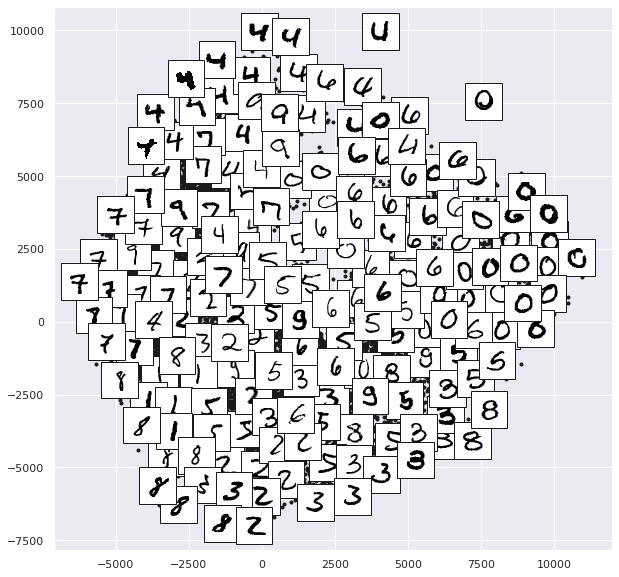

In [139]:
# не получилорсь с отображением одной цифры - выпадает ошибка в функции визуализации. надо подукмать как поправить
from sklearn.manifold import Isomap

# Choose 1/4 of the "1" digits to project
data = mnist.data[::4]

fig, ax = plt.subplots(figsize=(10, 10))
model = Isomap(n_neighbors=5, n_components=2, eigen_solver='dense')
plot_components(data, model, images=data.reshape((-1, 28, 28)),
                ax=ax, thumb_frac=0.05, cmap='gray_r')

### k-means для рукописных цифр

попробуем распознавать похожие цифры без использования разметки

In [1]:
from sklearn.datasets import load_digits
digits = load_digits()
digits.data.shape

(1797, 64)

In [3]:
# кластеризация
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=10, random_state=0)
clusters = kmeans.fit_predict(digits.data)
kmeans.cluster_centers_.shape

(10, 64)

Мы получили десять кластеров в 64-мерном пространстве. Центыр кластеров можно интерпретировать как изображения.

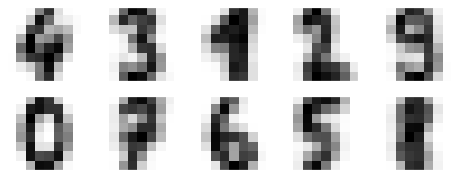

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import numpy as np

fig, ax = plt.subplots(2, 5, figsize=(8, 3))
centers = kmeans.cluster_centers_.reshape(10, 8, 8)
for axi, center in zip(ax.flat, centers):
    axi.set(xticks=[], yticks=[])
    axi.imshow(center, interpolation='nearest', cmap=plt.cm.binary)

In [6]:
# k-means ничего не знает о метках. Можно задачть соответствие
from scipy.stats import mode

labels = np.zeros_like(clusters)
for i in range(10):
    mask = (clusters == i)
    labels[mask] = mode(digits.target[mask])[0]

In [7]:
# теперь узнаем точность кластеризации
from sklearn.metrics import accuracy_score
accuracy_score(digits.target, labels)

0.7952142459654981

Text(89.18, 0.5, 'predicted label')

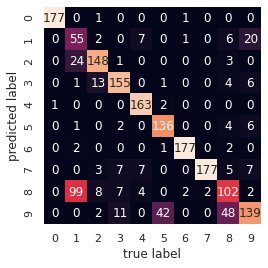

In [8]:
# матрица различий
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(digits.target, labels)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=digits.target_names,
            yticklabels=digits.target_names)
plt.xlabel('true label')
plt.ylabel('predicted label')

In [9]:
# воспользуемся t-SNE
from sklearn.manifold import TSNE

# Project the data: this step will take several seconds
tsne = TSNE(n_components=2, init='random', random_state=0)
digits_proj = tsne.fit_transform(digits.data)

# Compute the clusters
kmeans = KMeans(n_clusters=10, random_state=0)
clusters = kmeans.fit_predict(digits_proj)

# Permute the labels
labels = np.zeros_like(clusters)
for i in range(10):
    mask = (clusters == i)
    labels[mask] = mode(digits.target[mask])[0]

# Compute the accuracy
accuracy_score(digits.target, labels)

0.9371174179187535

### k-means для сжатия цветов

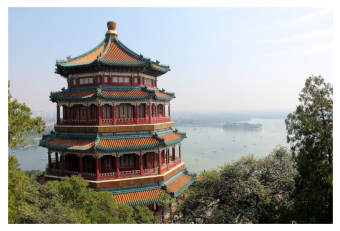

In [10]:
from sklearn.datasets import load_sample_image
china = load_sample_image("china.jpg")
ax = plt.axes(xticks=[], yticks=[])
ax.imshow(china)

In [12]:
china.shape

(427, 640, 3)

In [13]:
# изменим и масштабируем форму данных в шкалу между 0 и 1
data = china / 255.0 # use 0...1 scale
data = data.reshape(427 * 640, 3)
data.shape

(273280, 3)

In [14]:
def plot_pixels(data, title, colors=None, N=10000):
    if colors is None:
        colors = data
    
    # choose a random subset
    rng = np.random.RandomState(0)
    i = rng.permutation(data.shape[0])[:N]
    colors = colors[i]
    R, G, B = data[i].T
    
    fig, ax = plt.subplots(1, 2, figsize=(16, 6))
    ax[0].scatter(R, G, color=colors, marker='.')
    ax[0].set(xlabel='Red', ylabel='Green', xlim=(0, 1), ylim=(0, 1))

    ax[1].scatter(R, B, color=colors, marker='.')
    ax[1].set(xlabel='Red', ylabel='Blue', xlim=(0, 1), ylim=(0, 1))

    fig.suptitle(title, size=20)

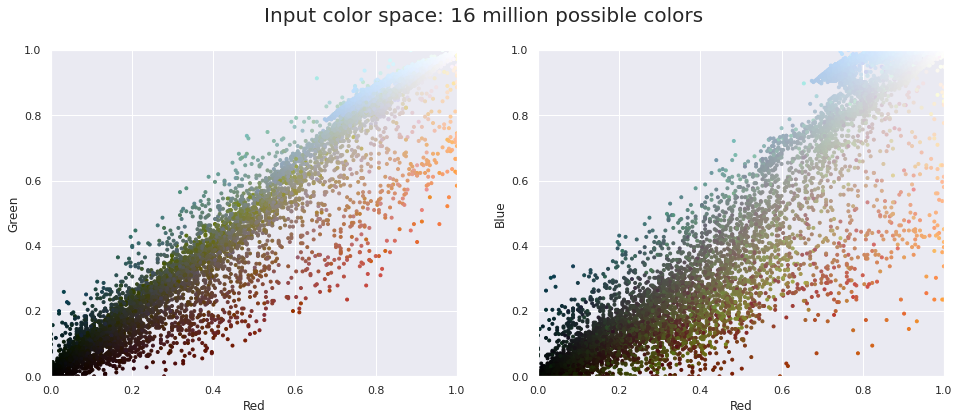

In [15]:
plot_pixels(data, title='Input color space: 16 million possible colors')

теперь уменьшим число цветов с 16млн. до 16 путем кластеризации методом k-means в пространстве пикселов. Набор очень большой - воспользуемся пакетным k-means

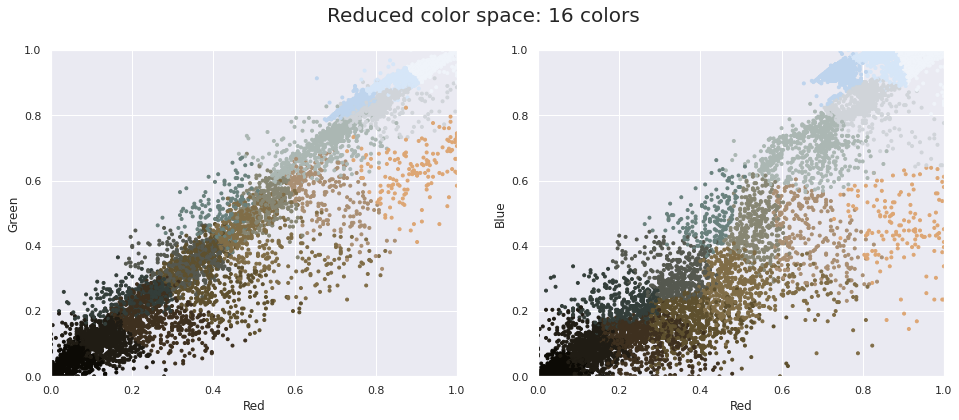

In [16]:
import warnings; warnings.simplefilter('ignore')  # Fix NumPy issues.

from sklearn.cluster import MiniBatchKMeans
kmeans = MiniBatchKMeans(16)
kmeans.fit(data)
new_colors = kmeans.cluster_centers_[kmeans.predict(data)]

plot_pixels(data, colors=new_colors,
            title="Reduced color space: 16 colors")

Text(0.5, 1.0, '16-color Image')

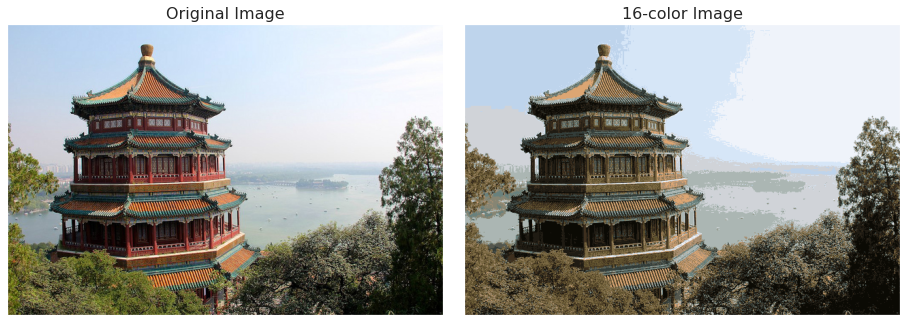

In [17]:
# результат
china_recolored = new_colors.reshape(china.shape)

fig, ax = plt.subplots(1, 2, figsize=(16, 6),
                       subplot_kw=dict(xticks=[], yticks=[]))
fig.subplots_adjust(wspace=0.05)
ax[0].imshow(china)
ax[0].set_title('Original Image', size=16)
ax[1].imshow(china_recolored)
ax[1].set_title('16-color Image', size=16)

### GMM для генерации новых данных

сгенерируем новые рукописные цифры

In [18]:
from sklearn.datasets import load_digits
digits = load_digits()
digits.data.shape

(1797, 64)

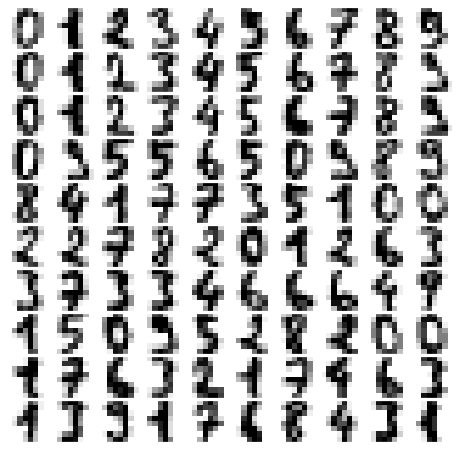

In [19]:
def plot_digits(data):
    fig, ax = plt.subplots(10, 10, figsize=(8, 8),
                           subplot_kw=dict(xticks=[], yticks=[]))
    fig.subplots_adjust(hspace=0.05, wspace=0.05)
    for i, axi in enumerate(ax.flat):
        im = axi.imshow(data[i].reshape(8, 8), cmap='binary')
        im.set_clim(0, 16)
plot_digits(digits.data)

GMM может не сойтись в пространстве такой размерности, поэтому лучше начать с примененеия обратимого алгоритма для понижения размерности. Используем PCA с сохраненеием 99% дисперсии

In [20]:
from sklearn.decomposition import PCA
pca = PCA(0.99, whiten=True)
data = pca.fit_transform(digits.data)
data.shape

(1797, 41)

Результат - 41 измеренеие практически без потери информации, на 1/3 лучше.

Выясним кол-во необходимых компонент с AIC для GMM

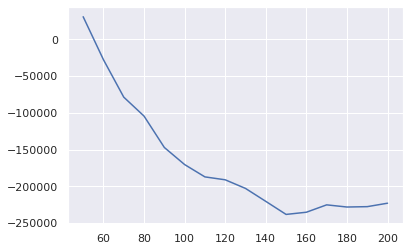

In [21]:
from sklearn.mixture import GaussianMixture
n_components = np.arange(50, 210, 10)
models = [GaussianMixture(n, covariance_type='full', random_state=0)
          for n in n_components]
aics = [model.fit(data).aic(data) for model in models]
plt.plot(n_components, aics)

Хватает 150. Обучим на этих компонентах модель.

In [22]:
gmm = GaussianMixture(110, covariance_type='full', random_state=0)
gmm.fit(data)
print(gmm.converged_)

True


модель сошлась. Сгенерируем 100 новых точек данных

In [24]:
data_new = gmm.sample(100)
np.asarray(data_new[0]).shape

(100, 41)

Выполним обратное преобразование объекта PCA и получим изображения

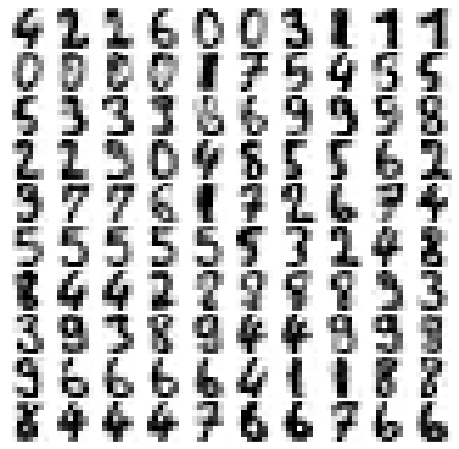

In [25]:
digits_new = pca.inverse_transform(np.asarray(data_new[0]))
plot_digits(digits_new)